# Testing GeoPandas overlaps: littoral, and tqv from two times

The basic object is [GeoPandas dataframes](https://geopandas.org/getting_started/introduction.html): 

![geopandas dataframe tableau](https://geopandas.org/_images/dataframe.svg "GeoPandas dataframe schema")

The `geometry` column contains shapely objects (polygons which may have holes), areas where CWV>55. Data columns can be anything -- area, rainrate from another dataset, or the ID tags of  active CCVLs (coast-crossing vapor lakes), of which each holey polygon is a part. A given polygon can be tagged as part of multiple CCVLs (having a notnull() entry in multiple data columns), because physically it may be destined to split into parts that will each separately cross the coast. 

In [65]:
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import fiona             # a read-write library for shapefiles
import os         
#from descartes.patch import PolygonPatch

from glob import glob
import xarray as xr
#import dask.array as da

import pandas as pd
import geopandas as gp

# A function to return a GeoDataFrame of polygons 

In [3]:
# loop over contour collections (and polygons in each collection)
# store in polylist  
def gdf_from_contours(lon,lat,tqv,conlevel):
    
    levels = [conlevel, 9e9]
    cs = plt.contourf(lon,lat,tqv,levels)
# create lookup table for levels
    lvl_lookup = dict(zip(cs.collections, cs.levels))
    
    zvalues, polylist  = [], []
#    i=0
    for col in cs.collections:
        z=lvl_lookup[col] # the value of this level
        for contour_path in col.get_paths():
#        print('contour path: ',i); i = i+1
        # create the polygon for this level
            for ncp,cp in enumerate(contour_path.to_polygons()):
#            print('   ncp: ', ncp)
                lons = np.array(cp)[:,0]
                lats = np.array(cp)[:,1]
                new_shape = geometry.Polygon([(i[0], i[1]) for i in zip(lons,lats)])            
                if ncp == 0:
                    poly = new_shape # first shape
                else:
                    poly = poly.difference(new_shape) # Remove the holes

            polylist.append(poly)
            zvalues.append(z)
        
        gdf = gp.GeoDataFrame(geometry=polylist)
        gdf['tqv_values']=zvalues
        gdf['area']=gdf.area
        return(gdf)

# Open the landmask and make a gdf of east coast 

In [125]:
land_msk = xr.open_dataset('landmask_MERRA2.nc')
eastcoast= (land_msk.lsm.squeeze().diff("lon") <0).astype(int)
lm = land_msk.sel(lon=slice(36,70),lat=slice(-20,20))
EAF = eastcoast.sel(lon=slice(36,70),lat=slice(-20,20))  # downsample it [::3, ::3]

In [ ]:
gdf_litt = gdf_from_contours(EAF.lon,EAF.lat,EAF,0.1)
#gdf_litt.plot(column='area', legend=True)

In [ ]:
#gdf_litt.geometry.bounds

In [ ]:
#gdf_litt.join(gdf_litt.geometry.bounds)

In [121]:
files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one
cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))

# Open the virtual (time series) dataset in xarray 

In [145]:
files = glob('MERRA2*.nc') #+glob('*2015*')+glob('*2016*')+glob('*2017*')+glob('*2018*') # selecting 2014-2018
cwv_data = xr.open_mfdataset(files) # merging data files in one
cwv_WEIO = cwv_data.sel(lat=slice(-30,30),lon=slice(30,90))

# Grab the later (destined) time level 

,geometry,tqv_values,area
0,"POLYGON ((58.75000 -10.51604, 58.77544 -10.500...",55.0,42.595260
1,"POLYGON ((88.75000 -9.87128, 88.16430 -9.50000...",55.0,258.886779
2,"POLYGON ((61.87500 -8.04756, 61.98258 -8.00000...",55.0,0.036614
3,"POLYGON ((62.50000 -4.05860, 62.57154 -4.00000...",55.0,0.706446
4,"POLYGON ((53.12500 -1.14258, 53.15765 -1.00000...",55.0,0.813496
5,"POLYGON ((65.62500 2.48853, 65.69610 2.50000, ...",55.0,0.001901
6,"POLYGON ((71.25000 4.45331, 71.87500 4.29712, ...",55.0,0.978947
7,"POLYGON ((56.87500 5.85807, 57.50000 5.96315, ...",55.0,0.549771
8,"POLYGON ((49.37500 6.95115, 50.00000 6.96510, ...",55.0,0.208567
9,"POLYGON ((33.75000 7.47262, 33.80174 7.50000, ...",55.0,0.813457


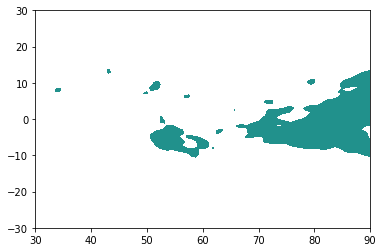

In [146]:
lon = cwv_WEIO.lon
lat = cwv_WEIO.lat
tqv = cwv_WEIO.TQV[3].values

gdf_destined = gdf_from_contours(lon,lat,tqv,55.)
gdf_destined

,geometry,tqv_values,area
0,"POLYGON ((89.64387 -11.50000, 89.37500 -11.387...",55.0,187.356451
1,"POLYGON ((53.12500 -10.56109, 53.47156 -10.500...",55.0,1.269263
2,"POLYGON ((53.75000 -8.70070, 54.22038 -8.50000...",55.0,14.351828
3,"POLYGON ((59.37500 -7.72917, 59.70920 -7.50000...",55.0,10.741246
4,"POLYGON ((56.25000 -4.56165, 56.87500 -4.89642...",55.0,1.522988
5,"POLYGON ((55.00000 -4.18653, 55.32342 -4.00000...",55.0,0.428718
6,"POLYGON ((64.37500 -3.14660, 64.93152 -3.00000...",55.0,0.105836
7,"POLYGON ((65.00000 1.92670, 65.62500 1.71592, ...",55.0,2.643069
8,"POLYGON ((54.37500 3.42998, 55.00000 3.12328, ...",55.0,19.917211
9,"POLYGON ((30.62500 3.96007, 30.72201 4.00000, ...",55.0,0.004781


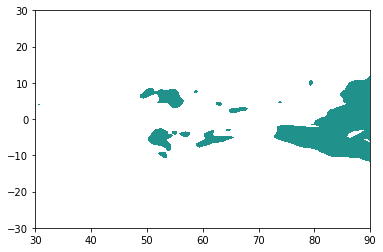

In [147]:
tqv = cwv_WEIO.TQV[23].values

gdf_destined = gdf_from_contours(lon,lat,tqv,55.)
gdf_destined

# Grab the present time level

,geometry,tqv_values,area
0,"POLYGON ((88.12500 -10.02020, 88.24098 -10.000...",55.0,225.984094
1,"POLYGON ((90.00000 -10.01531, 90.00000 -10.000...",55.0,0.186753
2,"POLYGON ((57.50000 -9.53604, 57.52261 -9.50000...",55.0,0.004809
3,"POLYGON ((56.87500 -9.09116, 57.25765 -9.00000...",55.0,28.002388
4,"POLYGON ((58.75000 -7.15710, 59.37500 -7.25306...",55.0,2.551614
5,"POLYGON ((56.87500 -5.01000, 57.03445 -5.00000...",55.0,0.001473
6,"POLYGON ((68.75000 -0.09805, 68.87256 -0.00000...",55.0,3.462117
7,"POLYGON ((65.62500 1.87057, 66.25000 1.99674, ...",55.0,1.052490
8,"POLYGON ((72.50000 3.93674, 73.12500 3.99034, ...",55.0,2.237743
9,"POLYGON ((31.87500 6.72584, 32.50000 6.85987, ...",55.0,2.494844


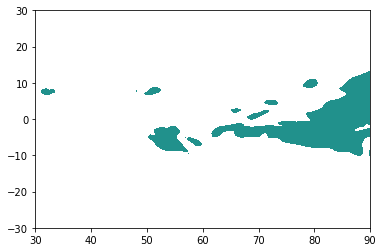

In [148]:
tqv = cwv_WEIO.TQV[10].values
gdf_now = gdf_from_contours(lon,lat,tqv,55.)
gdf_now

# Some basic plots 

<AxesSubplot:>

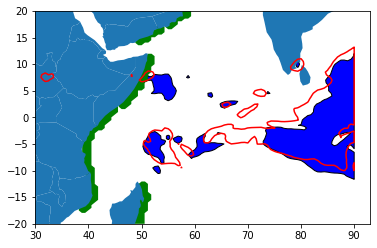

In [150]:
#https://geopandas.org/docs/user_guide/mapping.html
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(30, 93)
ax.set_ylim(-20,20)

gdf_destined.plot(ax=ax,color='blue', edgecolor='black')
gdf_now.boundary.plot(ax=ax, color='red')
gdf_litt.plot(ax=ax, color='green')

path = gp.datasets.get_path('naturalearth_lowres')
mapdf = gp.read_file(path)
mapdf.plot(ax=ax)

# Overlaps at last!! 

In [151]:
gdf_destined.geometry

0     POLYGON ((89.64387 -11.50000, 89.37500 -11.387...
1     POLYGON ((53.12500 -10.56109, 53.47156 -10.500...
2     POLYGON ((53.75000 -8.70070, 54.22038 -8.50000...
3     POLYGON ((59.37500 -7.72917, 59.70920 -7.50000...
4     POLYGON ((56.25000 -4.56165, 56.87500 -4.89642...
5     POLYGON ((55.00000 -4.18653, 55.32342 -4.00000...
6     POLYGON ((64.37500 -3.14660, 64.93152 -3.00000...
7     POLYGON ((65.00000 1.92670, 65.62500 1.71592, ...
8     POLYGON ((54.37500 3.42998, 55.00000 3.12328, ...
9     POLYGON ((30.62500 3.96007, 30.72201 4.00000, ...
10    POLYGON ((63.12500 3.75125, 63.38016 4.00000, ...
11    POLYGON ((73.75000 4.43699, 74.15225 4.50000, ...
12    POLYGON ((58.75000 7.38439, 59.02398 7.50000, ...
13    POLYGON ((79.37500 9.39082, 79.51906 9.50000, ...
Name: geometry, dtype: geometry

# Overlaps with coast (littoral) 

In [153]:
i_litt, i_now = gdf_now[(gdf_now.area>0)].sindex.query_bulk(gdf_litt.geometry, predicate='overlaps') 
i_litt, i_now # littoral only goes up 

(array([2]), array([10]))

In [154]:
# I tested the order here, destined and now are correct.
# but indices arrays are always the same size 
i_dest, i_now = gdf_now[(gdf_now.area>0)].sindex.query_bulk(gdf_destined.geometry, predicate='overlaps') # index numbers of overlaps
i_dest, i_now

(array([0, 2, 3, 3, 6, 7, 8]), array([ 0,  3,  4,  0,  0,  7, 10]))

In [158]:
_ih[:]

['',
 'from shapely import geometry\nimport matplotlib.pyplot as plt\nfrom matplotlib import cm\nimport numpy as np\nimport fiona             # a read-write library for shapefiles\nimport os,json           # json just a convenient way to dump some numbers (contour levels)\n#from descartes.patch import PolygonPatch\n\nfrom glob import glob\nimport xarray as xr\n#import dask.array as da\n\nimport geopandas as gp',
 'from shapely import geometry\nimport matplotlib.pyplot as plt\nfrom matplotlib import cm\nimport numpy as np\nimport fiona             # a read-write library for shapefiles\nimport os         \n#from descartes.patch import PolygonPatch\n\nfrom glob import glob\nimport xarray as xr\n#import dask.array as da\n\nimport geopandas as gp',
 "# loop over contour collections (and polygons in each collection)\n# store in polylist  \ndef gdf_from_contours(lon,lat,tqv,conlevel):\n    \n    levels = [conlevel, 9e9]\n    cs = plt.contourf(lon,lat,tqv,levels)\n# create lookup table for lev